In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u

In [3]:
from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel

from astropy.coordinates import SkyCoord

import ogip_spectrum_dataset
from models import XspecSpectralModel

from astromodels.xspec.factory import XS_wabs
from astromodels import Powerlaw

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available
[INFO    ] Starting 3ML!
Loading xspec models...done


In [40]:
filename = "../XMM_test_files/PN_PWN.grp"
pn_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)
filename = "../XMM_test_files/MOS1_PWN.grp"
mos1_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)
filename = "../XMM_test_files/MOS2_PWN.grp"
mos2_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)

In [ ]:
pn_dataset.group

(1.0, 10.0)

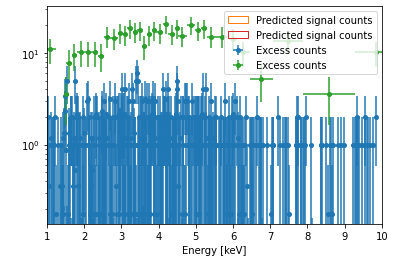

In [5]:
ax = pn_dataset.plot_excess()
ax = pn_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

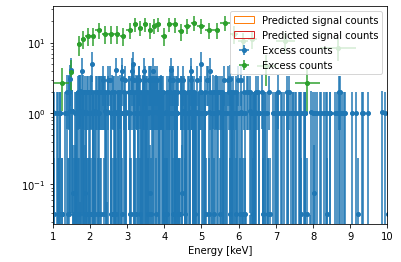

In [6]:
ax = mos1_dataset.plot_excess()
ax = mos1_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

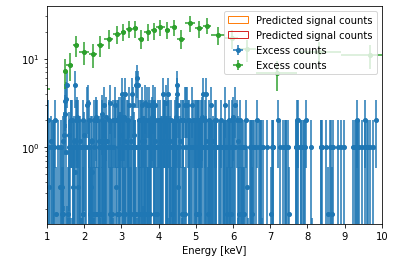

In [7]:
ax = mos2_dataset.plot_excess()
ax = mos2_dataset.grouped.plot_excess()
plt.xlim(1,10)

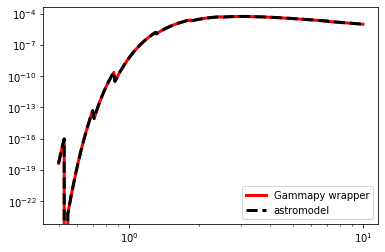

In [37]:
fig, ax = plt.subplots()
energy_grid = np.linspace(0.5, 10.0, 1000) * u.keV

plaw = Powerlaw(index=-2, K=1e-3, piv=1)
abs_model = XS_wabs(nh=5)

# Gammapy wrapper
f1 = XspecSpectralModel(plaw) 
f2 = XspecSpectralModel(abs_model)
f3 = f1 * f2
ax.loglog(energy_grid, f3(energy_grid), color="r", lw=3, label="Gammapy wrapper")

#Plain astromodels
plaw_with_abs = plaw * abs_model
ax.loglog(energy_grid.value, plaw_with_abs(energy_grid.value), color="k", ls="--", lw=3, label="astromodel")

plt.legend()

In [9]:
model = SkyModel(spectral_model=f3)

In [10]:
from gammapy.datasets import Datasets
xmm_datasets = Datasets(datasets=[pn_dataset, mos1_dataset, mos2_dataset])
xmm_datasets.models=[model]

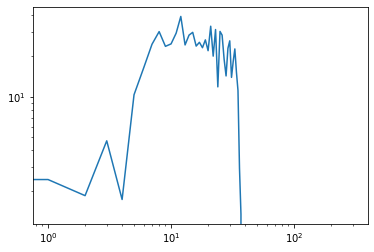

In [11]:
plt.loglog(np.squeeze(pn_dataset.npred_signal().data))

In [12]:
xmm_datasets.models[0].spectral_model.parameters["piv"].frozen = True
xmm_datasets.models[0].spectral_model.parameters["K"].min = 0
xmm_datasets.models[0].spectral_model.parameters["nh"].min = 0

In [13]:
xmm_datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str8,str8,str5,float64,str1,int64,float64,float64,bool,str1
55QNKTxT,spectral,K,1.0000e-03,,0.000e+00,0.000e+00,nan,False,
55QNKTxT,spectral,piv,1.0000e+00,,0.000e+00,nan,nan,True,
55QNKTxT,spectral,index,-2.0000e+00,,0.000e+00,nan,nan,False,
55QNKTxT,spectral,nh,5.0000e+00,,0.000e+00,0.000e+00,nan,False,


In [14]:
%%time
fit = Fit()
fit_result = fit.run(xmm_datasets)

CPU times: user 46.4 s, sys: 3.28 ms, total: 46.4 s
Wall time: 46.4 s


In [15]:
print(fit_result.parameters.to_table())

  type    name    value    unit   error      min    max frozen link
-------- ----- ----------- ---- --------- --------- --- ------ ----
spectral     K  4.7251e-04      2.111e-04 0.000e+00 nan  False     
spectral   piv  1.0000e+00      0.000e+00       nan nan   True     
spectral index -1.7351e+00      2.628e-01       nan nan  False     
spectral    nh  5.6632e+00      8.781e-01 0.000e+00 nan  False     


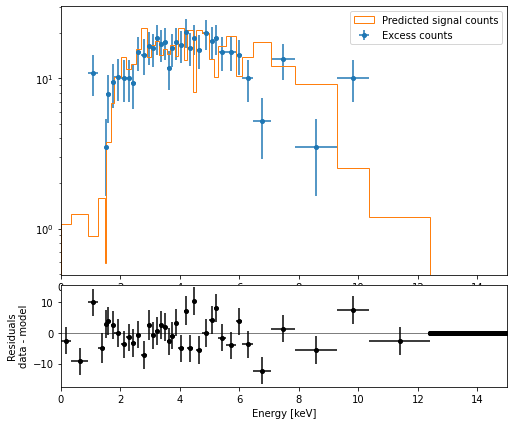

In [16]:
pn_dataset.plot_fit()

<AxesSubplot:xlabel='Energy [keV]', ylabel='Residuals (data - model)'>

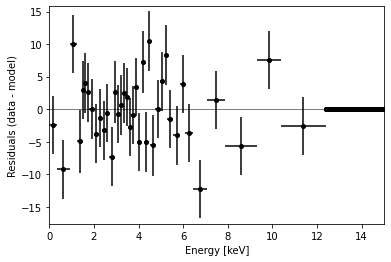

In [17]:
pn_dataset.plot_residuals_spectral()

In [18]:
for dataset in xmm_datasets:
    dataset.mask_fit = dataset.counts.geom.energy_mask(5*u.keV, 10*u.keV)

In [19]:
pn_dataset.mask_fit

RegionNDMap

	geom  : RegionGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (1, 1, 299)
	ndim  : 3
	unit  : 
	dtype : bool

In [20]:
fit = Fit()
fit_result = fit.run(xmm_datasets)

In [21]:
print(fit_result.parameters.to_table())

  type    name    value    unit   error      min    max frozen link
-------- ----- ----------- ---- --------- --------- --- ------ ----
spectral     K  2.3929e-03      4.391e-03 0.000e+00 nan  False     
spectral   piv  1.0000e+00      0.000e+00       nan nan   True     
spectral index -2.7319e+00      1.048e+00       nan nan  False     
spectral    nh  1.0136e-04      5.631e-02 0.000e+00 nan  False     


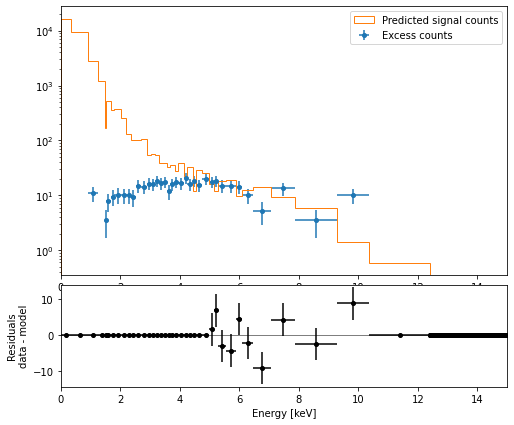

In [22]:
pn_dataset.plot_fit()